# GPQA-D Performance Regression Analysis

This notebook performs multiple regression analysis to understand how GPQA-D performance improves over time.

**Key Questions:**
1. How much does performance improve per year **without controlling for price**?
2. How much does performance improve per year **controlling for price**?
3. What is the effect of price on performance?

**Methodology:**
- Dependent variable: logit(GPQA-D) = log(p / (1-p))
- Independent variables: Time (years since start), log(Price)
- Two models:
  - Model 1: logit(GPQA-D) ~ time
  - Model 2: logit(GPQA-D) ~ time + log(price)
- Option to use Pareto frontier only or all models

In [185]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats

## Load and Prepare Data

In [186]:
# Define logit transformation functions
def logit(p):
    """Convert probability to logit scale"""
    p_clipped = np.clip(p, 0.001, 0.999)
    return np.log(p_clipped / (1 - p_clipped))

def inverse_logit(logit_val):
    """Convert logit back to probability"""
    return 1 / (1 + np.exp(-logit_val))

In [187]:
# Load the data
df = pd.read_csv('data/price_reduction_models.csv')

# Convert Release Date to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Clean GPQA-D column (epoch_gpqa) - convert percentage strings to floats
df['GPQA_D'] = df['epoch_gpqa'].astype(str).str.replace('%', '').astype(float)

# Clean Benchmark Cost USD - convert string with $ and commas to float
df['Price'] = df['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Filter out rows with missing data
df_clean = df[['Model', 'Release Date', 'GPQA_D', 'Price']].dropna()
df_clean = df_clean[df_clean['Price'] > 0]

print(f"Total models with complete data: {len(df_clean)}")
print(f"Date range: {df_clean['Release Date'].min()} to {df_clean['Release Date'].max()}")
print(f"GPQA-D range: {df_clean['GPQA_D'].min():.1f}% to {df_clean['GPQA_D'].max():.1f}%")
print(f"Price range: ${df_clean['Price'].min():.2f} to ${df_clean['Price'].max():.2f}")

Open weight models: 75, Proprietary models: 63
Total models with complete data: 138
Date range: 2024-04-01 00:00:00 to 2025-10-01 00:00:00
GPQA-D range: 13.2% to 86.2%
Price range: $0.00 to $76.30


In [188]:
# Add logit column (convert percentage to decimal first)
df_clean['GPQA_D_logit'] = logit(df_clean['GPQA_D'] / 100)

# Add log price (for regression)
df_clean['log_Price'] = np.log10(df_clean['Price'])

# Add ordinal date for regression (normalize to years for interpretability)
min_date_ordinal = df_clean['Release Date'].min().toordinal()
df_clean['Date_Ordinal'] = df_clean['Release Date'].map(datetime.toordinal)
df_clean['Years_Since_Start'] = (df_clean['Date_Ordinal'] - min_date_ordinal) / 365.25

print("\nTransformations complete:")
print(f"Logit(GPQA-D) range: {df_clean['GPQA_D_logit'].min():.2f} to {df_clean['GPQA_D_logit'].max():.2f}")
print(f"Log10(Price) range: {df_clean['log_Price'].min():.2f} to {df_clean['log_Price'].max():.2f}")
print(f"Years since start: 0 to {df_clean['Years_Since_Start'].max():.2f}")


Transformations complete:
Logit(GPQA-D) range: -1.88 to 1.83
Log10(Price) range: -2.35 to 1.88
Years since start: 0 to 1.50


## Regression Analysis Function

This function performs two regressions:
1. **Model 1**: logit(GPQA-D) ~ time (no price control)
2. **Model 2**: logit(GPQA-D) ~ time + log(price) (controlling for price)

We use sklearn LinearRegression with manual calculation of statistics (standard errors, p-values, confidence intervals).

In [ ]:
def _run_two_regressions(df_analysis, analysis_type):
    """Run the with/without price-control regressions on a pre-filtered sample."""
    print(f"\n{'='*80}")
    print(f"Analyzing {len(df_analysis)} models ({analysis_type})")
    print(
        f"Date range: {df_analysis['Release Date'].min().strftime('%Y-%m-%d')} to {df_analysis['Release Date'].max().strftime('%Y-%m-%d')}"
    )
    print(f"GPQA-D range: {df_analysis['GPQA_D'].min():.1f}% to {df_analysis['GPQA_D'].max():.1f}%")
    print(f"{'='*80}\n")

    # Prepare data for regression
    y = df_analysis['GPQA_D_logit'].values
    X_time = df_analysis[['Years_Since_Start']].values
    X_time_price = df_analysis[['Years_Since_Start', 'log_Price']].values

    # Model 1: logit(GPQA-D) ~ time (no price control)
    model1 = LinearRegression().fit(X_time, y)
    y_pred1 = model1.predict(X_time)

    # Model 2: logit(GPQA-D) ~ time + log(price) (controlling for price)
    model2 = LinearRegression().fit(X_time_price, y)
    y_pred2 = model2.predict(X_time_price)

    # Calculate R-squared
    r_squared1 = model1.score(X_time, y)
    r_squared2 = model2.score(X_time_price, y)

    # Calculate statistics for Model 1
    n1 = len(y)
    residuals1 = y - y_pred1
    mse1 = np.sum(residuals1**2) / (n1 - 2)  # n - p - 1, where p=1

    # Standard error for time coefficient (Model 1)
    X_time_centered = X_time - np.mean(X_time)
    se_time1 = np.sqrt(mse1 / np.sum(X_time_centered**2))

    # t-statistic and p-value
    t_stat1 = model1.coef_[0] / se_time1
    p_value1 = 2 * (1 - stats.t.cdf(np.abs(t_stat1), n1 - 2))

    # 95% confidence interval
    t_crit1 = stats.t.ppf(0.975, n1 - 2)
    ci_lower1 = model1.coef_[0] - t_crit1 * se_time1
    ci_upper1 = model1.coef_[0] + t_crit1 * se_time1

    # Calculate statistics for Model 2
    n2 = len(y)
    residuals2 = y - y_pred2
    mse2 = np.sum(residuals2**2) / (n2 - 3)  # n - p - 1, where p=2

    # Standard errors for coefficients (Model 2)
    # Using the formula: SE = sqrt(MSE * (X'X)^-1)
    XtX_inv = np.linalg.inv(X_time_price.T @ X_time_price)
    se_coefs2 = np.sqrt(np.diag(XtX_inv) * mse2)

    se_time2 = se_coefs2[0]
    se_price2 = se_coefs2[1]

    # t-statistics and p-values
    t_stat_time2 = model2.coef_[0] / se_time2
    t_stat_price2 = model2.coef_[1] / se_price2

    p_value_time2 = 2 * (1 - stats.t.cdf(np.abs(t_stat_time2), n2 - 3))
    p_value_price2 = 2 * (1 - stats.t.cdf(np.abs(t_stat_price2), n2 - 3))

    # 95% confidence intervals
    t_crit2 = stats.t.ppf(0.975, n2 - 3)
    ci_lower_time2 = model2.coef_[0] - t_crit2 * se_time2
    ci_upper_time2 = model2.coef_[0] + t_crit2 * se_time2

    # Calculate approximate percentage point improvements
    mean_gpqa = df_analysis['GPQA_D'].mean()
    mean_logit_val = logit(mean_gpqa / 100)

    # Model 1: annual improvement
    future_logit_1 = mean_logit_val + model1.coef_[0]
    future_prob_1 = inverse_logit(future_logit_1) * 100
    annual_pct_1 = future_prob_1 - mean_gpqa

    # Model 2: annual improvement
    future_logit_2 = mean_logit_val + model2.coef_[0]
    future_prob_2 = inverse_logit(future_logit_2) * 100
    annual_pct_2 = future_prob_2 - mean_gpqa

    # Create summary results
    results = []

    # Model 1 results
    results.append({
        'Model': 'Without Price Control',
        'Specification': 'logit(GPQA-D) ~ time',
        'Time_Coefficient': model1.coef_[0],
        'Time_Std_Err': se_time1,
        'Time_p_value': p_value1,
        'Time_CI_Lower': ci_lower1,
        'Time_CI_Upper': ci_upper1,
        'Annual_Improvement_Logits': model1.coef_[0],
        'Annual_Improvement_PctPts': annual_pct_1,
        'Price_Coefficient': np.nan,
        'Price_Std_Err': np.nan,
        'Price_p_value': np.nan,
        'R_Squared': r_squared1,
        'Adj_R_Squared': 1 - (1 - r_squared1) * (n1 - 1) / (n1 - 2),
        'N_Models': len(df_analysis),
        'Mean_GPQA_D': mean_gpqa
    })

    # Model 2 results
    results.append({
        'Model': 'With Price Control',
        'Specification': 'logit(GPQA-D) ~ time + log(price)',
        'Time_Coefficient': model2.coef_[0],
        'Time_Std_Err': se_time2,
        'Time_p_value': p_value_time2,
        'Time_CI_Lower': ci_lower_time2,
        'Time_CI_Upper': ci_upper_time2,
        'Annual_Improvement_Logits': model2.coef_[0],
        'Annual_Improvement_PctPts': annual_pct_2,
        'Price_Coefficient': model2.coef_[1],
        'Price_Std_Err': se_price2,
        'Price_p_value': p_value_price2,
        'R_Squared': r_squared2,
        'Adj_R_Squared': 1 - (1 - r_squared2) * (n2 - 1) / (n2 - 3),
        'N_Models': len(df_analysis),
        'Mean_GPQA_D': mean_gpqa
    })

    results_df = pd.DataFrame(results)

    return {
        'results_df': results_df,
        'model1': model1,
        'model2': model2,
        'data': df_analysis,
        'analysis_type': analysis_type
    }


def perform_regression_analysis(df, use_pareto_only=True, min_date=None):
    """Perform regression on either the Pareto frontier sample or all models."""

    df_work = df.copy()

    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]

    # Sort by date
    df_work = df_work.sort_values('Release Date')

    # Get Pareto frontier if requested
    if use_pareto_only:
        # Identify Pareto frontier models at each point in time
        # A model is on the Pareto frontier if no other model dominates it
        # (i.e., no model with both better/equal performance and lower/equal price)
        pareto_indices = []

        for date in df_work['Release Date'].unique():
            # Get all models available at this date
            available_models = df_work[df_work['Release Date'] <= date].copy()

            # Find Pareto frontier at this date
            available_models = available_models.sort_values(['Price', 'GPQA_D'])
            frontier_indices = []

            for i, row in available_models.iterrows():
                # Check if this model is on the Pareto frontier
                dominated = False
                for j in frontier_indices:
                    frontier_row = available_models.loc[j]
                    # A model is dominated if there exists another model with:
                    # 1. Better or equal GPQA-D score AND
                    # 2. Lower or equal price
                    # AND at least one is strictly better
                    if (
                        frontier_row['GPQA_D'] >= row['GPQA_D']
                        and frontier_row['Price'] <= row['Price']
                        and (
                            frontier_row['GPQA_D'] > row['GPQA_D']
                            or frontier_row['Price'] < row['Price']
                        )
                    ):
                        dominated = True
                        break

                if not dominated:
                    frontier_indices.append(i)
                    # Remove any previously added models that this one dominates
                    new_frontier_indices = []
                    for j in frontier_indices[:-1]:
                        frontier_row = available_models.loc[j]
                        if not (
                            row['GPQA_D'] >= frontier_row['GPQA_D']
                            and row['Price'] <= frontier_row['Price']
                            and (
                                row['GPQA_D'] > frontier_row['GPQA_D']
                                or row['Price'] < frontier_row['Price']
                            )
                        ):
                            new_frontier_indices.append(j)
                    frontier_indices = new_frontier_indices + [i]

            # Add models released exactly on this date that are on the frontier
            current_date_models = df_work[df_work['Release Date'] == date]
            for i, row in current_date_models.iterrows():
                if i in frontier_indices:
                    pareto_indices.append(i)

        # Remove duplicates and use for regression
        pareto_indices = list(set(pareto_indices))
        df_analysis = df_work.loc[pareto_indices].copy()
        analysis_type = "Pareto Frontier"
    else:
        df_analysis = df_work.copy()
        analysis_type = "All Models"

    return _run_two_regressions(df_analysis, analysis_type)


def perform_frontier_regression_analysis(df, min_date=None):
    """Perform regression on performance frontier models.

    Performance frontier = models that achieve strictly better GPQA-D than any previously released model.
    """
    df_work = df.copy()

    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]

    df_work = df_work.sort_values(['Release Date', 'GPQA_D'])

    prev_best = df_work['GPQA_D'].cummax().shift(1)
    df_work['Is_Performance_Frontier'] = df_work['GPQA_D'] > prev_best.fillna(-np.inf)

    df_analysis = df_work[df_work['Is_Performance_Frontier']].copy()
    analysis_type = "Performance Frontier (new best GPQA-D over time)"

    return _run_two_regressions(df_analysis, analysis_type)

## Analysis 1: Pareto Frontier

Using only the best-performing models over time (Pareto frontier).

In [190]:
# Run analysis on Pareto frontier
print("\n" + "="*100)
print("ANALYSIS 1: PARETO FRONTIER")
print("="*100)
results_pareto = perform_regression_analysis(
    df_clean,
    use_pareto_only=True,
    min_date=datetime(2024, 4, 1)
)


ANALYSIS 1: PARETO FRONTIER

Analyzing 53 models (Pareto Frontier)
Date range: 2024-04-01 to 2025-09-01
GPQA-D range: 25.2% to 86.2%



## Analysis 2: All Models

Using all models in the dataset.

In [191]:
# Run analysis on all models
print("\n" + "="*100)
print("ANALYSIS 2: ALL MODELS")
print("="*100)
results_all = perform_regression_analysis(
    df_clean,
    use_pareto_only=False,
    min_date=datetime(2024, 4, 1)
)

# Run analysis on performance frontier (new best GPQA-D over time)
print("\n" + "="*100)
print("ANALYSIS 3: PERFORMANCE FRONTIER (NEW BEST GPQA-D OVER TIME)")
print("="*100)
results_frontier = perform_frontier_regression_analysis(
    df_clean,
    min_date=datetime(2024, 4, 1)
)


ANALYSIS 2: ALL MODELS

Analyzing 138 models (All Models)
Date range: 2024-04-01 to 2025-10-01
GPQA-D range: 13.2% to 86.2%


ANALYSIS 3: PERFORMANCE FRONTIER (NEW BEST GPQA-D OVER TIME)

Analyzing 7 models (Performance Frontier (new best GPQA-D over time))
Date range: 2024-04-01 to 2025-08-01
GPQA-D range: 59.5% to 86.2%



## Load and Prepare SWE-Bench and AIME Data

Now let's load and prepare data for SWE-Bench and AIME to compare across benchmarks.

In [192]:
# Load SWE-Bench data
df_swe = pd.read_csv('data/price_reduction_models.csv')

# Convert Release Date to datetime
df_swe['Release Date'] = pd.to_datetime(df_swe['Release Date'])

# Clean SWE-Bench column (epoch_swe) - convert percentage strings to floats
df_swe['SWE_Bench'] = df_swe['epoch_swe'].astype(str).str.replace('%', '').astype(float)

# Clean Benchmark Cost USD - convert string with $ and commas to float
df_swe['Price'] = df_swe['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df_swe['Price'] = pd.to_numeric(df_swe['Price'], errors='coerce')

# Filter out rows with missing data
df_swe_clean = df_swe[['Model', 'Release Date', 'SWE_Bench', 'Price']].dropna()
df_swe_clean = df_swe_clean[df_swe_clean['Price'] > 0]
df_swe_clean = df_swe_clean[df_swe_clean['SWE_Bench'] > 0]

# Add logit column (convert percentage to decimal first)
df_swe_clean['SWE_Bench_logit'] = logit(df_swe_clean['SWE_Bench'] / 100)

# Add log price (for regression)
df_swe_clean['log_Price'] = np.log10(df_swe_clean['Price'])

# Add ordinal date for regression (normalize to years for interpretability)
min_date_ordinal_swe = df_swe_clean['Release Date'].min().toordinal()
df_swe_clean['Date_Ordinal'] = df_swe_clean['Release Date'].map(datetime.toordinal)
df_swe_clean['Years_Since_Start'] = (df_swe_clean['Date_Ordinal'] - min_date_ordinal_swe) / 365.25

print(f"SWE-Bench: Total models with complete data: {len(df_swe_clean)}")
print(f"Date range: {df_swe_clean['Release Date'].min()} to {df_swe_clean['Release Date'].max()}")
print(f"SWE-Bench range: {df_swe_clean['SWE_Bench'].min():.1f}% to {df_swe_clean['SWE_Bench'].max():.1f}%")
print(f"Price range: ${df_swe_clean['Price'].min():.2f} to ${df_swe_clean['Price'].max():.2f}")

SWE-Bench: Open weight models: 4, Proprietary models: 15
SWE-Bench: Total models with complete data: 19
Date range: 2024-10-01 00:00:00 to 2025-10-01 00:00:00
SWE-Bench range: 16.4% to 64.8%
Price range: $0.05 to $10.67


In [ ]:
# Multi-benchmark regression function - must be defined before use
def perform_benchmark_regression(df, name, score_col, logit_col, use_pareto_only=True, min_date=None):
    """Perform regression for any benchmark (not just GPQA-D)."""
    df_work = df.copy()
    if min_date: 
        df_work = df_work[df_work['Release Date'] >= pd.to_datetime(min_date)]
    df_work = df_work.sort_values('Release Date')
    
    if use_pareto_only:
        pareto_indices = []
        for date in df_work['Release Date'].unique():
            avail = df_work[df_work['Release Date'] <= date].copy().sort_values(['Price', score_col])
            frontier = []
            for i, row in avail.iterrows():
                dominated = any(avail.loc[j, score_col] >= row[score_col] and avail.loc[j, 'Price'] <= row['Price'] 
                               and (avail.loc[j, score_col] > row[score_col] or avail.loc[j, 'Price'] < row['Price']) for j in frontier)
                if not dominated:
                    frontier = [j for j in frontier if not (row[score_col] >= avail.loc[j, score_col] and row['Price'] <= avail.loc[j, 'Price']
                                                             and (row[score_col] > avail.loc[j, score_col] or row['Price'] < avail.loc[j, 'Price']))] + [i]
            pareto_indices.extend([i for i, _ in df_work[df_work['Release Date'] == date].iterrows() if i in frontier])
        df_analysis = df_work.loc[list(set(pareto_indices))].copy()
        analysis_type = f"{name} Pareto Frontier"
    else:
        df_analysis = df_work.copy()
        analysis_type = f"{name} All Models"
    
    if len(df_analysis) < 3:
        print(f"Warning: Not enough data for {analysis_type} (n={len(df_analysis)})")
        return None
    
    y = df_analysis[logit_col].values
    X_t = df_analysis[['Years_Since_Start']].values
    X_tp = df_analysis[['Years_Since_Start', 'log_Price']].values
    m1 = LinearRegression().fit(X_t, y)
    m2 = LinearRegression().fit(X_tp, y)
    n = len(y)
    se1 = np.sqrt(np.sum((y - m1.predict(X_t))**2) / (n-2) / np.sum((X_t - X_t.mean())**2))
    XtX_inv = np.linalg.inv(X_tp.T @ X_tp)
    se2 = np.sqrt(np.diag(XtX_inv) * np.sum((y - m2.predict(X_tp))**2) / (n-3))
    t1, t2 = m1.coef_[0]/se1, m2.coef_[0]/se2[0]
    p1, p2 = 2*(1-stats.t.cdf(abs(t1), n-2)), 2*(1-stats.t.cdf(abs(t2), n-3))
    mean_score = df_analysis[score_col].mean()
    ann1 = inverse_logit(logit(mean_score/100) + m1.coef_[0])*100 - mean_score
    ann2 = inverse_logit(logit(mean_score/100) + m2.coef_[0])*100 - mean_score
    
    print(f"\n{analysis_type}: {n} models")
    
    return {'results_df': pd.DataFrame([
        {'Benchmark': name, 'Model': 'Without Price Control', 'Time_Coefficient': m1.coef_[0], 'Time_Std_Err': se1,
         'Time_p_value': p1, 'Annual_Improvement_PctPts': ann1, 'Price_Coefficient': np.nan, 'N_Models': n,
         'R_Squared': m1.score(X_t, y), 'Adj_R_Squared': 1-(1-m1.score(X_t, y))*(n-1)/(n-2)},
        {'Benchmark': name, 'Model': 'With Price Control', 'Time_Coefficient': m2.coef_[0], 'Time_Std_Err': se2[0],
         'Time_p_value': p2, 'Annual_Improvement_PctPts': ann2, 'Price_Coefficient': m2.coef_[1], 'N_Models': n,
         'R_Squared': m2.score(X_tp, y), 'Adj_R_Squared': 1-(1-m2.score(X_tp, y))*(n-1)/(n-3)}
    ]), 'model1': m1, 'model2': m2, 'data': df_analysis}


def perform_frontier_benchmark_regression(df, name, score_col, logit_col, min_date=None):
    """Perform regression on performance frontier models for any benchmark.
    
    Performance frontier = models that achieve strictly better score than any previously released model.
    """
    df_work = df.copy()
    if min_date:
        df_work = df_work[df_work['Release Date'] >= pd.to_datetime(min_date)]
    
    df_work = df_work.sort_values(['Release Date', score_col])
    
    prev_best = df_work[score_col].cummax().shift(1)
    df_work['Is_Performance_Frontier'] = df_work[score_col] > prev_best.fillna(-np.inf)
    
    df_analysis = df_work[df_work['Is_Performance_Frontier']].copy()
    analysis_type = f"{name} Performance Frontier"
    
    if len(df_analysis) < 3:
        print(f"Warning: Not enough data for {analysis_type} (n={len(df_analysis)})")
        return None
    
    y = df_analysis[logit_col].values
    X_t = df_analysis[['Years_Since_Start']].values
    X_tp = df_analysis[['Years_Since_Start', 'log_Price']].values
    m1 = LinearRegression().fit(X_t, y)
    m2 = LinearRegression().fit(X_tp, y)
    n = len(y)
    se1 = np.sqrt(np.sum((y - m1.predict(X_t))**2) / (n-2) / np.sum((X_t - X_t.mean())**2))
    XtX_inv = np.linalg.inv(X_tp.T @ X_tp)
    se2 = np.sqrt(np.diag(XtX_inv) * np.sum((y - m2.predict(X_tp))**2) / (n-3))
    t1, t2 = m1.coef_[0]/se1, m2.coef_[0]/se2[0]
    p1, p2 = 2*(1-stats.t.cdf(abs(t1), n-2)), 2*(1-stats.t.cdf(abs(t2), n-3))
    mean_score = df_analysis[score_col].mean()
    ann1 = inverse_logit(logit(mean_score/100) + m1.coef_[0])*100 - mean_score
    ann2 = inverse_logit(logit(mean_score/100) + m2.coef_[0])*100 - mean_score
    
    print(f"\n{analysis_type}: {n} models")
    
    return {'results_df': pd.DataFrame([
        {'Benchmark': name, 'Model': 'Without Price Control', 'Time_Coefficient': m1.coef_[0], 'Time_Std_Err': se1,
         'Time_p_value': p1, 'Annual_Improvement_PctPts': ann1, 'Price_Coefficient': np.nan, 'N_Models': n,
         'R_Squared': m1.score(X_t, y), 'Adj_R_Squared': 1-(1-m1.score(X_t, y))*(n-1)/(n-2)},
        {'Benchmark': name, 'Model': 'With Price Control', 'Time_Coefficient': m2.coef_[0], 'Time_Std_Err': se2[0],
         'Time_p_value': p2, 'Annual_Improvement_PctPts': ann2, 'Price_Coefficient': m2.coef_[1], 'N_Models': n,
         'R_Squared': m2.score(X_tp, y), 'Adj_R_Squared': 1-(1-m2.score(X_tp, y))*(n-1)/(n-3)}
    ]), 'model1': m1, 'model2': m2, 'data': df_analysis}

## Multi-Benchmark Summary Table

In [ ]:
# Load AIME data  
df_aime = pd.read_csv('data/aime_price_reduction_models.csv')
df_aime['Release Date'] = pd.to_datetime(df_aime['Release Date'])
df_aime['AIME'] = df_aime['epoch_AIME_nosamp'].astype(str).str.replace('%', '').astype(float)
df_aime['Price'] = df_aime['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df_aime['Price'] = pd.to_numeric(df_aime['Price'], errors='coerce')
df_aime_clean = df_aime[['Model', 'Release Date', 'AIME', 'Price']].dropna()
df_aime_clean = df_aime_clean[(df_aime_clean['Price'] > 0) & (df_aime_clean['AIME'] > 0)]
df_aime_clean['AIME_logit'] = logit(df_aime_clean['AIME'] / 100)
df_aime_clean['log_Price'] = np.log10(df_aime_clean['Price'])
min_date_ordinal_aime = df_aime_clean['Release Date'].min().toordinal()
df_aime_clean['Date_Ordinal'] = df_aime_clean['Release Date'].map(datetime.toordinal)
df_aime_clean['Years_Since_Start'] = (df_aime_clean['Date_Ordinal'] - min_date_ordinal_aime) / 365.25
print(f"\nAIME: {len(df_aime_clean)} models, {df_aime_clean['AIME'].min():.1f}%-{df_aime_clean['AIME'].max():.1f}%")

AIME: Open weight models: 25, Proprietary models: 36

AIME: 61 models, 0.6%-91.4%


In [195]:
# Run SWE-Bench regressions (Pareto, Frontier, All)
print("\n" + "="*80)
print("SWE-BENCH REGRESSIONS")
print("="*80)
results_swe_pareto = perform_benchmark_regression(df_swe_clean, 'SWE-Bench', 'SWE_Bench', 'SWE_Bench_logit', True, datetime(2024, 4, 1))
results_swe_frontier = perform_frontier_benchmark_regression(df_swe_clean, 'SWE-Bench', 'SWE_Bench', 'SWE_Bench_logit', datetime(2024, 4, 1))
results_swe_all = perform_benchmark_regression(df_swe_clean, 'SWE-Bench', 'SWE_Bench', 'SWE_Bench_logit', False, datetime(2024, 4, 1))

# Run AIME regressions (Pareto, Frontier, All)
print("\n" + "="*80)
print("AIME REGRESSIONS")
print("="*80)
results_aime_pareto = perform_benchmark_regression(df_aime_clean, 'AIME', 'AIME', 'AIME_logit', True, datetime(2024, 4, 1))
results_aime_frontier = perform_frontier_benchmark_regression(df_aime_clean, 'AIME', 'AIME', 'AIME_logit', datetime(2024, 4, 1))
results_aime_all = perform_benchmark_regression(df_aime_clean, 'AIME', 'AIME', 'AIME_logit', False, datetime(2024, 4, 1))


SWE-BENCH REGRESSIONS

SWE-Bench Pareto Frontier: 10 models

SWE-Bench Performance Frontier: 6 models

SWE-Bench All Models: 19 models

AIME REGRESSIONS

AIME Pareto Frontier: 27 models

AIME Performance Frontier: 8 models

AIME All Models: 61 models


In [196]:
# Create multi-benchmark summary table
rows = []

# Helper to add results for a benchmark
def add_benchmark_rows(results_list, benchmark_name, sample_names):
    for r, sample_name in zip(results_list, sample_names):
        if r is None:
            continue
        for _, row in r['results_df'].iterrows():
            rows.append({
                'Benchmark': benchmark_name, 
                'Sample': sample_name, 
                'Model': row['Model'], 
                'N': int(row['N_Models']), 
                'Time Coef': row['Time_Coefficient'],
                'Time SE': row['Time_Std_Err'], 
                'Time p': row['Time_p_value'], 
                'Annual Δ (% pts)': row['Annual_Improvement_PctPts'], 
                'Price Coef': row['Price_Coefficient'],
                'R²': row['R_Squared'], 
                'Adj R²': row['Adj_R_Squared']
            })

# GPQA-D results (Pareto, Frontier, All)
add_benchmark_rows([results_pareto, results_frontier, results_all], 'GPQA-D', ['Pareto', 'Frontier', 'All'])

# SWE-Bench results (Pareto, Frontier, All)
add_benchmark_rows([results_swe_pareto, results_swe_frontier, results_swe_all], 'SWE-Bench', ['Pareto', 'Frontier', 'All'])

# AIME results (Pareto, Frontier, All)
add_benchmark_rows([results_aime_pareto, results_aime_frontier, results_aime_all], 'AIME', ['Pareto', 'Frontier', 'All'])

summary = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)
print("\n" + "="*120)
print("MULTI-BENCHMARK REGRESSION SUMMARY")
print("="*120)
print(summary.to_string(index=False))
summary.to_csv('results/multi_benchmark_summary.csv', index=False)
print("\n\nSaved to: results/multi_benchmark_summary.csv")


MULTI-BENCHMARK REGRESSION SUMMARY
Benchmark   Sample                 Model   N  Time Coef  Time SE     Time p  Annual Δ (% pts)  Price Coef     R²  Adj R²
   GPQA-D   Pareto Without Price Control  53     1.2955   0.2161 2.0830e-07           27.3904         NaN 0.4134  0.4019
   GPQA-D   Pareto    With Price Control  53     0.6783   0.0551 2.2204e-16           15.9361      0.5710 0.8806  0.8758
   GPQA-D Frontier Without Price Control   7     1.0068   0.0757 4.2983e-05           13.6759         NaN 0.9725  0.9670
   GPQA-D Frontier    With Price Control   7     1.0327   0.1042 5.8258e-04           13.9147     -0.0207 0.9731  0.9597
   GPQA-D      All Without Price Control 138     0.9640   0.1294 9.6665e-12           21.9442         NaN 0.2899  0.2847
   GPQA-D      All    With Price Control 138     0.5933   0.0393 0.0000e+00           14.2169      0.4998 0.7366  0.7326
SWE-Bench   Pareto Without Price Control  10     1.3861   0.5264 3.0036e-02           29.3706         NaN 0.4643  0.3


OPEN WEIGHT MODELS REGRESSIONS

Analyzing 35 models (Open Weight Pareto Frontier)
Date range: 2024-04-01 to 2025-09-01
GPQA-D range: 25.9% to 76.3%


Analyzing 5 models (Open Weight Performance Frontier (new best GPQA-D over time))
Date range: 2024-04-01 to 2025-06-01
GPQA-D range: 30.6% to 76.3%


Analyzing 75 models (Open Weight All Models)
Date range: 2024-04-01 to 2025-10-01
GPQA-D range: 13.2% to 76.3%


SWE-Bench Pareto Frontier: 4 models

SWE-Bench All Models: 4 models

AIME Pareto Frontier: 16 models

AIME Performance Frontier: 4 models

AIME All Models: 25 models



OPEN WEIGHT MODELS - MULTI-BENCHMARK REGRESSION SUMMARY
Benchmark   Sample                 Model  N  Time Coef  Time SE     Time p  Annual Δ (% pts)  Price Coef     R²  Adj R²
   GPQA-D   Pareto Without Price Control 35     0.9126   0.2533 1.0210e-03           22.0579         NaN 0.2824  0.2606
   GPQA-D   Pareto    With Price Control 35     0.7298   0.1051 7.2724e-08           17.9159      0.7167 0.7999  0.7874
   GPQA-D Frontier Without Price Control  5     1.4209   0.6234 1.0702e-01           29.0187         NaN 0.6339  0.5119
   GPQA-D Frontier    With Price Control  5    -0.3813   0.2524 2.7007e-01           -9.4993      1.1844 0.9362  0.8725
   GPQA-D      All Without Price Control 75     0.6361   0.1655 2.5562e-04           15.7355         NaN 0.1684  0.1570
   GPQA-D      All    With Price Control 75     0.3290   0.0717 1.8295e-05            8.1995      0.5487 0.5833  0.5717
SWE-Bench   Pareto Without Price Control  4    -0.8023   2.9669 8.1219e-01          -11.9397         Na

In [199]:
# Create comprehensive summary table
print("\n\n" + "="*120)
print("COMPREHENSIVE SUMMARY TABLE")
print("="*120 + "\n")

summary_rows = []

# Add Pareto frontier results
for _, row in results_pareto['results_df'].iterrows():
    summary_rows.append({
        'Sample': 'Pareto Frontier',
        'Model': row['Model'],
        'N': int(row['N_Models']),
        'Time Coef (logits/yr)': row['Time_Coefficient'],
        'Time Std Err': row['Time_Std_Err'],
        'Time p-value': row['Time_p_value'],
        '95% CI Lower': row['Time_CI_Lower'],
        '95% CI Upper': row['Time_CI_Upper'],
        'Annual Δ (% pts)': row['Annual_Improvement_PctPts'],
        'Price Coef': row['Price_Coefficient'],
        'Price p-value': row['Price_p_value'],
        'R²': row['R_Squared'],
        'Adj R²': row['Adj_R_Squared']
    })

# Add performance frontier results
for _, row in results_frontier['results_df'].iterrows():
    summary_rows.append({
        'Sample': 'Performance Frontier',
        'Model': row['Model'],
        'N': int(row['N_Models']),
        'Time Coef (logits/yr)': row['Time_Coefficient'],
        'Time Std Err': row['Time_Std_Err'],
        'Time p-value': row['Time_p_value'],
        '95% CI Lower': row['Time_CI_Lower'],
        '95% CI Upper': row['Time_CI_Upper'],
        'Annual Δ (% pts)': row['Annual_Improvement_PctPts'],
        'Price Coef': row['Price_Coefficient'],
        'Price p-value': row['Price_p_value'],
        'R²': row['R_Squared'],
        'Adj R²': row['Adj_R_Squared']
    })

# Add all models results
for _, row in results_all['results_df'].iterrows():
    summary_rows.append({
        'Sample': 'All Models',
        'Model': row['Model'],
        'N': int(row['N_Models']),
        'Time Coef (logits/yr)': row['Time_Coefficient'],
        'Time Std Err': row['Time_Std_Err'],
        'Time p-value': row['Time_p_value'],
        '95% CI Lower': row['Time_CI_Lower'],
        '95% CI Upper': row['Time_CI_Upper'],
        'Annual Δ (% pts)': row['Annual_Improvement_PctPts'],
        'Price Coef': row['Price_Coefficient'],
        'Price p-value': row['Price_p_value'],
        'R²': row['R_Squared'],
        'Adj R²': row['Adj_R_Squared']
    })

summary_table = pd.DataFrame(summary_rows)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)

print(summary_table.to_string(index=False))

# Save to CSV
summary_table.to_csv('results/gpqa_regression_summary.csv', index=False)
print("\n\nSummary table saved to: results/gpqa_regression_summary.csv")



COMPREHENSIVE SUMMARY TABLE

              Sample                 Model   N  Time Coef (logits/yr)  Time Std Err  Time p-value  95% CI Lower  95% CI Upper  Annual Δ (% pts)  Price Coef  Price p-value     R²  Adj R²
     Pareto Frontier Without Price Control  53                 1.2955        0.2161    2.0830e-07        0.8617        1.7293           27.3904         NaN            NaN 0.4134  0.4019
     Pareto Frontier    With Price Control  53                 0.6783        0.0551    2.2204e-16        0.5676        0.7891           15.9361      0.5710         0.0000 0.8806  0.8758
Performance Frontier Without Price Control   7                 1.0068        0.0757    4.2983e-05        0.8122        1.2014           13.6759         NaN            NaN 0.9725  0.9670
Performance Frontier    With Price Control   7                 1.0327        0.1042    5.8258e-04        0.7433        1.3221           13.9147     -0.0207         0.7726 0.9731  0.9597
          All Models Without Price Cont

## Key Insights

In [200]:
# Print key insights
print("\n\n" + "="*100)
print("KEY INSIGHTS")
print("="*100)

pareto_no_control = results_pareto['results_df'][results_pareto['results_df']['Model'] == 'Without Price Control'].iloc[0]
pareto_with_control = results_pareto['results_df'][results_pareto['results_df']['Model'] == 'With Price Control'].iloc[0]

frontier_no_control = results_frontier['results_df'][results_frontier['results_df']['Model'] == 'Without Price Control'].iloc[0]
frontier_with_control = results_frontier['results_df'][results_frontier['results_df']['Model'] == 'With Price Control'].iloc[0]

print("\n1. PARETO FRONTIER (Best Models Over Time):")
print(f"   N = {int(pareto_no_control['N_Models'])} models\n")

print("   Without controlling for price:")
print(f"   - Annual improvement: {pareto_no_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {pareto_no_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - R² = {pareto_no_control['R_Squared']:.3f}")
print(f"   - p-value: {pareto_no_control['Time_p_value']:.4f}\n")

print("   Controlling for price:")
print(f"   - Annual improvement: {pareto_with_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {pareto_with_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - Price effect: {pareto_with_control['Price_Coefficient']:.3f} logits per 10x price increase")
print(f"   - R² = {pareto_with_control['R_Squared']:.3f}")
print(f"   - Time p-value: {pareto_with_control['Time_p_value']:.4f}")
print(f"   - Price p-value: {pareto_with_control['Price_p_value']:.4f}\n")

coef_change_pareto = pareto_with_control['Annual_Improvement_Logits'] - pareto_no_control['Annual_Improvement_Logits']
pct_change_pareto = (coef_change_pareto / pareto_no_control['Annual_Improvement_Logits']) * 100

print("   Effect of controlling for price:")
print(f"   - Coefficient change: {coef_change_pareto:.3f} logits/yr ({pct_change_pareto:+.1f}%)")
if coef_change_pareto < 0:
    print("   - Interpretation: Some of the apparent progress is due to higher prices")
else:
    print("   - Interpretation: Progress is independent of (or enhanced beyond) price effects")

print("\n2. PERFORMANCE FRONTIER (New Best GPQA-D Over Time):")
print(f"   N = {int(frontier_no_control['N_Models'])} models\n")

print("   Without controlling for price:")
print(f"   - Annual improvement: {frontier_no_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {frontier_no_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - R² = {frontier_no_control['R_Squared']:.3f}")
print(f"   - p-value: {frontier_no_control['Time_p_value']:.4f}\n")

print("   Controlling for price:")
print(f"   - Annual improvement: {frontier_with_control['Annual_Improvement_Logits']:.3f} logits/yr")
print(f"   - Approximate: {frontier_with_control['Annual_Improvement_PctPts']:.2f} percentage points/yr")
print(f"   - Price effect: {frontier_with_control['Price_Coefficient']:.3f} logits per 10x price increase")
print(f"   - R² = {frontier_with_control['R_Squared']:.3f}")
print(f"   - Time p-value: {frontier_with_control['Time_p_value']:.4f}")
print(f"   - Price p-value: {frontier_with_control['Price_p_value']:.4f}\n")

coef_change_frontier = frontier_with_control['Annual_Improvement_Logits'] - frontier_no_control['Annual_Improvement_Logits']
pct_change_frontier = (coef_change_frontier / frontier_no_control['Annual_Improvement_Logits']) * 100

print("   Effect of controlling for price:")
print(f"   - Coefficient change: {coef_change_frontier:.3f} logits/yr ({pct_change_frontier:+.1f}%)")
if coef_change_frontier < 0:
    print("   - Interpretation: Some of the apparent progress is due to higher prices")
else:
    print("   - Interpretation: Progress is independent of (or enhanced beyond) price effects")

print("\n" + "="*100)



KEY INSIGHTS

1. PARETO FRONTIER (Best Models Over Time):
   N = 53 models

   Without controlling for price:
   - Annual improvement: 1.295 logits/yr
   - Approximate: 27.39 percentage points/yr
   - R² = 0.413
   - p-value: 0.0000

   Controlling for price:
   - Annual improvement: 0.678 logits/yr
   - Approximate: 15.94 percentage points/yr
   - Price effect: 0.571 logits per 10x price increase
   - R² = 0.881
   - Time p-value: 0.0000
   - Price p-value: 0.0000

   Effect of controlling for price:
   - Coefficient change: -0.617 logits/yr (-47.6%)
   - Interpretation: Some of the apparent progress is due to higher prices

2. PERFORMANCE FRONTIER (New Best GPQA-D Over Time):
   N = 7 models

   Without controlling for price:
   - Annual improvement: 1.007 logits/yr
   - Approximate: 13.68 percentage points/yr
   - R² = 0.973
   - p-value: 0.0000

   Controlling for price:
   - Annual improvement: 1.033 logits/yr
   - Approximate: 13.91 percentage points/yr
   - Price effect: -0.02

## Interpretation Guide

**Time Coefficient (logits/yr)**: The annual rate of improvement in logit(GPQA-D). Higher = faster improvement.

**Annual Δ (% pts)**: Approximate annual improvement in percentage points, calculated at the mean performance level. More interpretable than logit units.

**Price Coefficient**: Effect of 10x increase in price on logit(GPQA-D). Positive = higher price models perform better.

**Without vs. With Price Control**:
- **Without**: Shows total performance improvement over time (includes effect of higher prices)
- **With**: Shows performance improvement holding price constant (pure algorithmic/data progress)
- **Difference**: Reveals how much of the progress is due to price vs. other factors

**R²**: Proportion of variance explained. Higher = better fit.

**p-values**: Statistical significance. p < 0.05 typically considered significant.

### Interpreting Partial Regression Plots

**What do these plots show?**

Partial regression plots (added-variable plots) visualize the **unique contribution** of each predictor variable after removing the effects of other predictors.

**Left plot - Time Effect (controlling for Price):**
- X-axis: Time residuals (variation in time not explained by price)
- Y-axis: Performance residuals (variation in performance not explained by price)
- The slope equals the **time coefficient** from the full model
- Shows: How much performance improves over time, holding price constant

**Right plot - Price Effect (controlling for Time):**
- X-axis: Price residuals (variation in price not explained by time)
- Y-axis: Performance residuals (variation in performance not explained by time)
- The slope equals the **price coefficient** from the full model
- Shows: How much performance improves with price, holding time constant

**Key Insights:**
- Strong linear patterns indicate the variable is important after controlling for others
- Scatter indicates the relationship after removing confounding effects
- The R² in each plot shows how much variance that predictor explains uniquely

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_regression(df_analysis, model2, use_pareto_only=True, sample_label=None):
    """Create partial regression plots for the multiple regression model.

    For Model 2: logit(GPQA-D) ~ time + log(price)
    - Plot 1: Shows time effect after controlling for price
    - Plot 2: Shows price effect after controlling for time

    Args:
        sample_label: Optional override label for the figure title.
    """
    
    # Prepare data
    y = df_analysis['GPQA_D_logit'].values
    X_time = df_analysis['Years_Since_Start'].values.reshape(-1, 1)
    X_price = df_analysis['log_Price'].values.reshape(-1, 1)
    
    # Partial regression for Time (controlling for Price)
    # 1. Regress y on price only
    model_y_on_price = LinearRegression().fit(X_price, y)
    residuals_y = y - model_y_on_price.predict(X_price)
    
    # 2. Regress time on price
    model_time_on_price = LinearRegression().fit(X_price, X_time.ravel())
    residuals_time = X_time.ravel() - model_time_on_price.predict(X_price)
    
    # Partial regression for Price (controlling for Time)
    # 1. Regress y on time only
    model_y_on_time = LinearRegression().fit(X_time, y)
    residuals_y_2 = y - model_y_on_time.predict(X_time)
    
    # 2. Regress price on time
    model_price_on_time = LinearRegression().fit(X_time, X_price.ravel())
    residuals_price = X_price.ravel() - model_price_on_time.predict(X_time)
    
    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Time partial regression
    ax1 = axes[0]
    ax1.scatter(residuals_time, residuals_y, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Add regression line
    slope_time = model2.coef_[0]
    x_range = np.array([residuals_time.min(), residuals_time.max()])
    y_range = slope_time * x_range
    ax1.plot(x_range, y_range, 'r-', linewidth=2, label=f'Slope = {slope_time:.3f}')
    
    ax1.set_xlabel('Time (Years Since Start) | Others', fontsize=12, fontweight='bold')
    ax1.set_ylabel('logit(GPQA-D) | Others', fontsize=12, fontweight='bold')
    ax1.set_title('Partial Regression: Time Effect\n(Controlling for Price)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    
    # Add R² for this relationship
    ss_res = np.sum((residuals_y - slope_time * residuals_time)**2)
    ss_tot = np.sum((residuals_y - np.mean(residuals_y))**2)
    r2_time = 1 - ss_res/ss_tot
    ax1.text(0.05, 0.95, f'R² = {r2_time:.3f}', transform=ax1.transAxes, 
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Price partial regression
    ax2 = axes[1]
    ax2.scatter(residuals_price, residuals_y_2, alpha=0.6, s=80, edgecolors='black', linewidth=0.5, color='orange')
    
    # Add regression line
    slope_price = model2.coef_[1]
    x_range_price = np.array([residuals_price.min(), residuals_price.max()])
    y_range_price = slope_price * x_range_price
    ax2.plot(x_range_price, y_range_price, 'r-', linewidth=2, label=f'Slope = {slope_price:.3f}')
    
    ax2.set_xlabel('log₁₀(Price) | Others', fontsize=12, fontweight='bold')
    ax2.set_ylabel('logit(GPQA-D) | Others', fontsize=12, fontweight='bold')
    ax2.set_title('Partial Regression: Price Effect\n(Controlling for Time)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    
    # Add R² for this relationship
    ss_res_price = np.sum((residuals_y_2 - slope_price * residuals_price)**2)
    ss_tot_price = np.sum((residuals_y_2 - np.mean(residuals_y_2))**2)
    r2_price = 1 - ss_res_price/ss_tot_price
    ax2.text(0.05, 0.95, f'R² = {r2_price:.3f}', transform=ax2.transAxes, 
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Overall title
    sample_type = sample_label if sample_label is not None else ("Pareto Frontier" if use_pareto_only else "All Models")
    fig.suptitle(f'Partial Regression Plots - {sample_type} (N={len(df_analysis)})', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

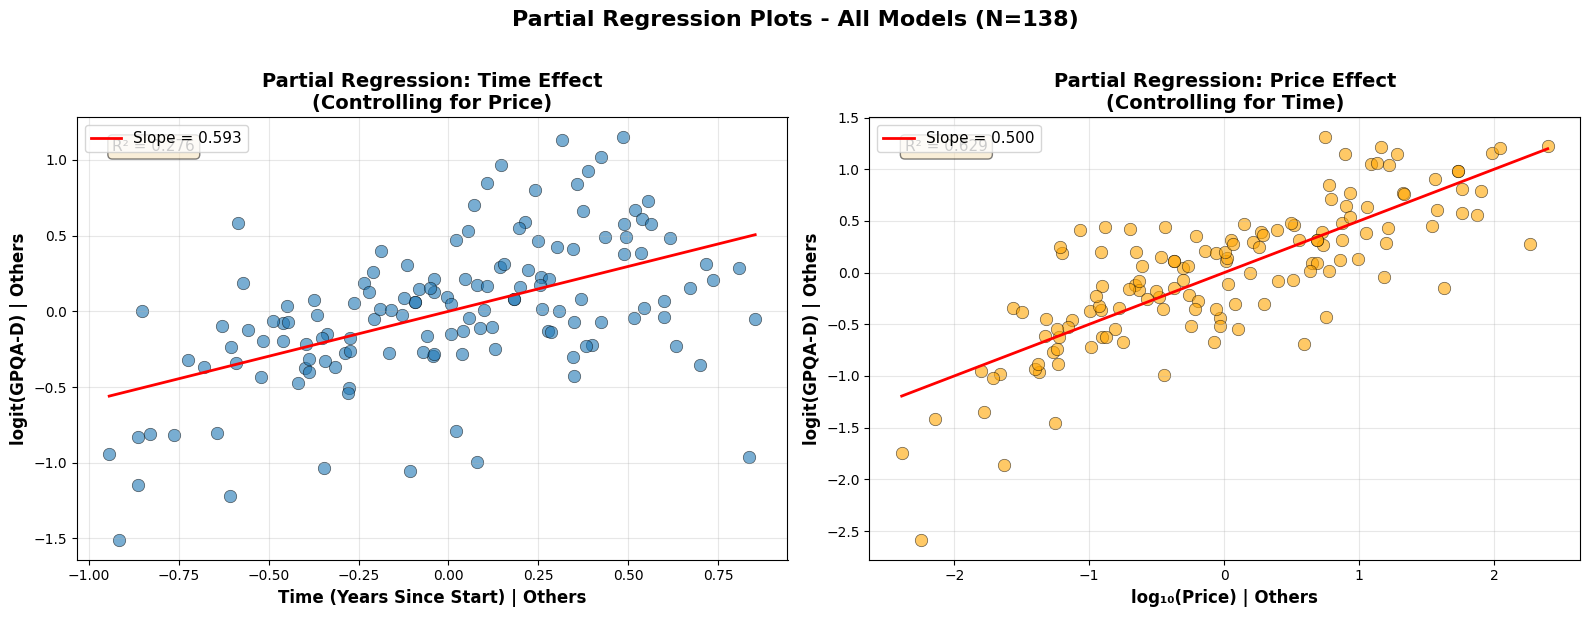

In [202]:
# Generate partial regression plots for all models
fig_all, axes_all = plot_partial_regression(
    results_all['data'], 
    results_all['model2'], 
    use_pareto_only=False)

### All Models Partial Regression Plots

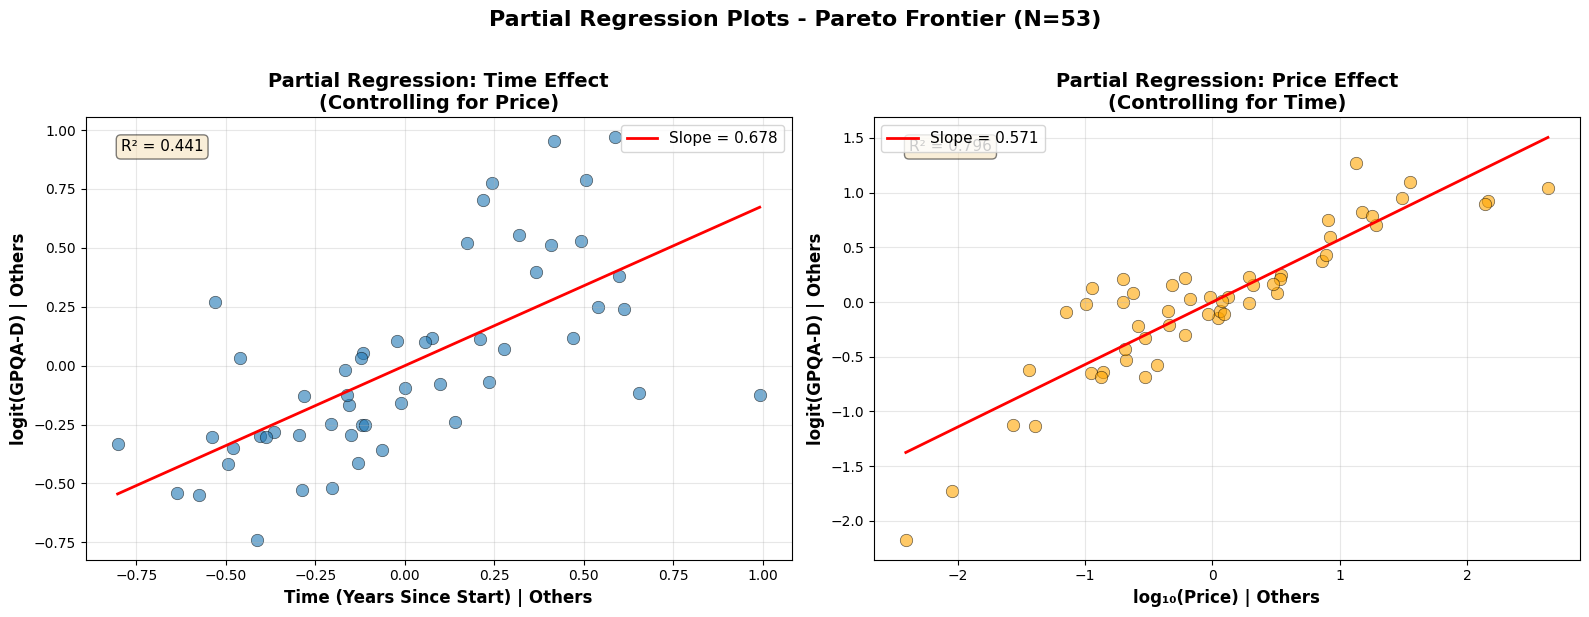

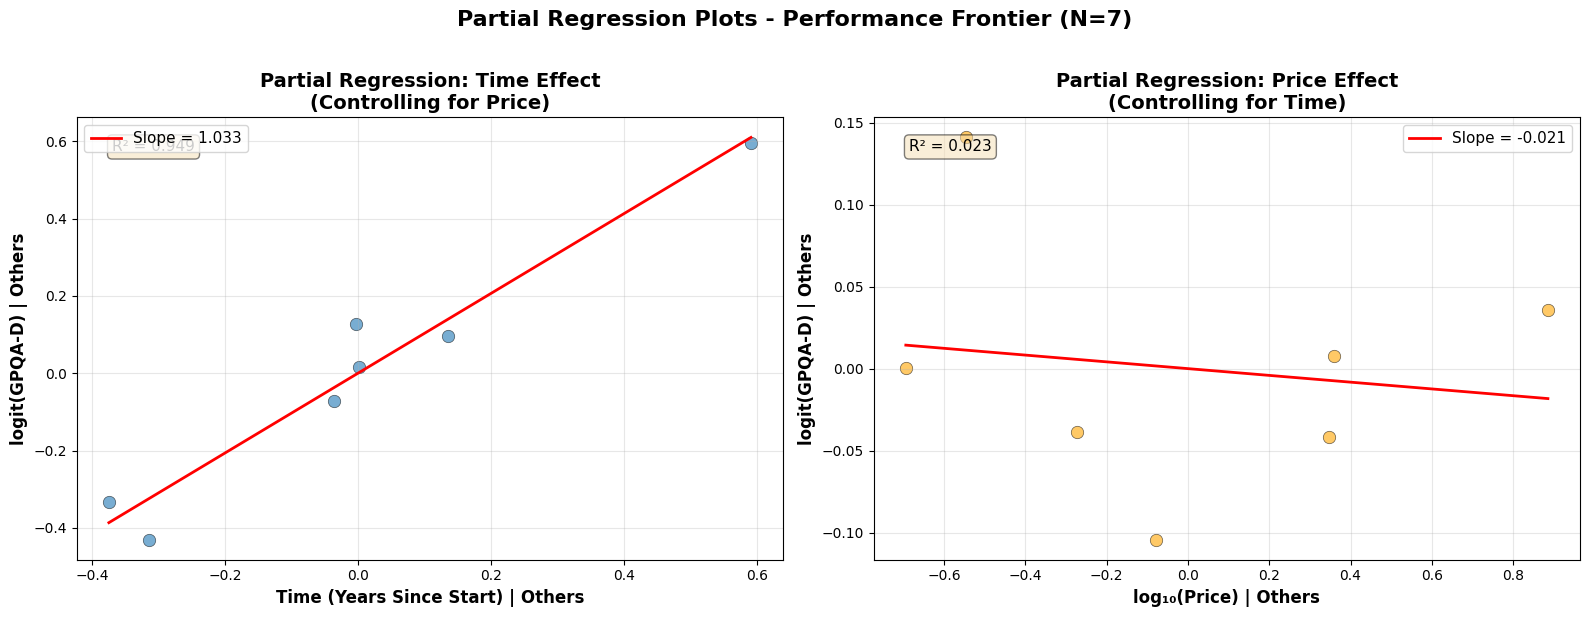

In [203]:
# Generate partial regression plots for Pareto frontier
fig_pareto, axes_pareto = plot_partial_regression(
    results_pareto['data'],
    results_pareto['model2'],
    use_pareto_only=True,
    sample_label="Pareto Frontier"
)

# Generate partial regression plots for performance frontier
fig_frontier, axes_frontier = plot_partial_regression(
    results_frontier['data'],
    results_frontier['model2'],
    use_pareto_only=False,
    sample_label="Performance Frontier"
)

### Pareto Frontier Partial Regression Plots

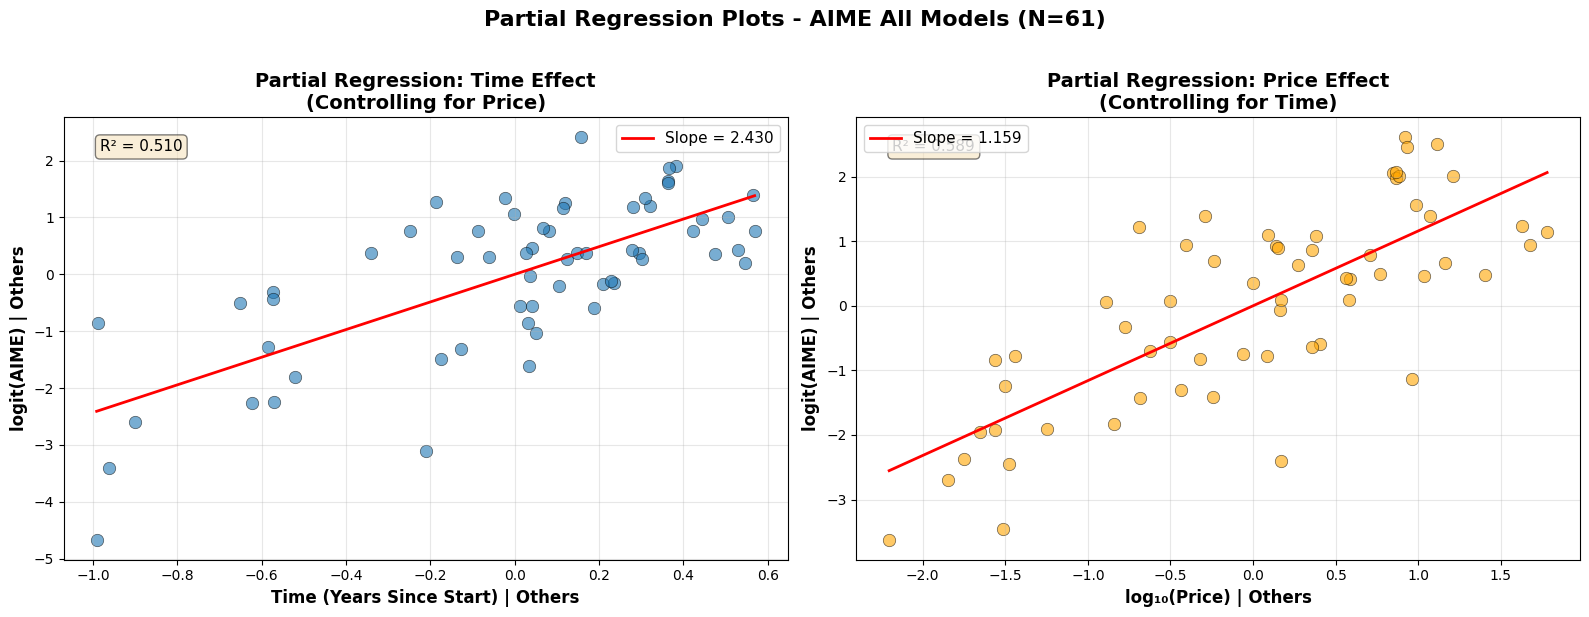

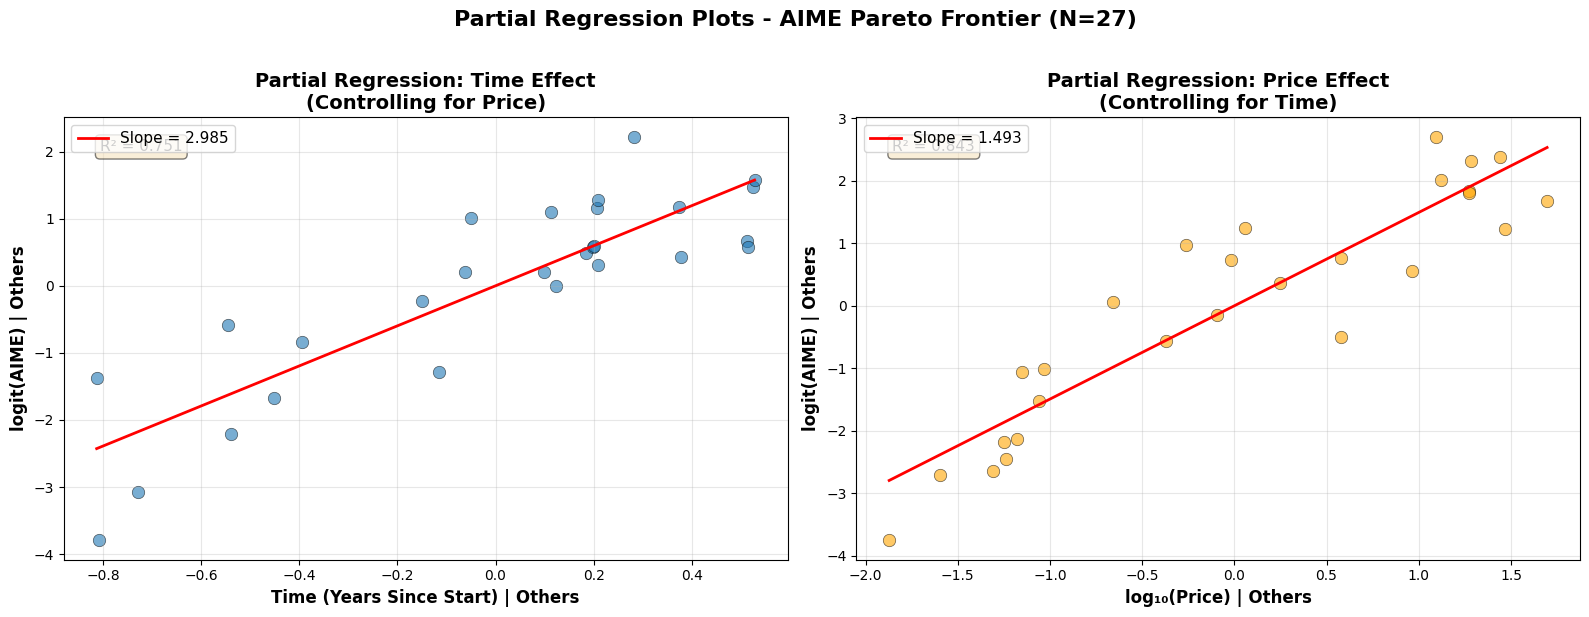

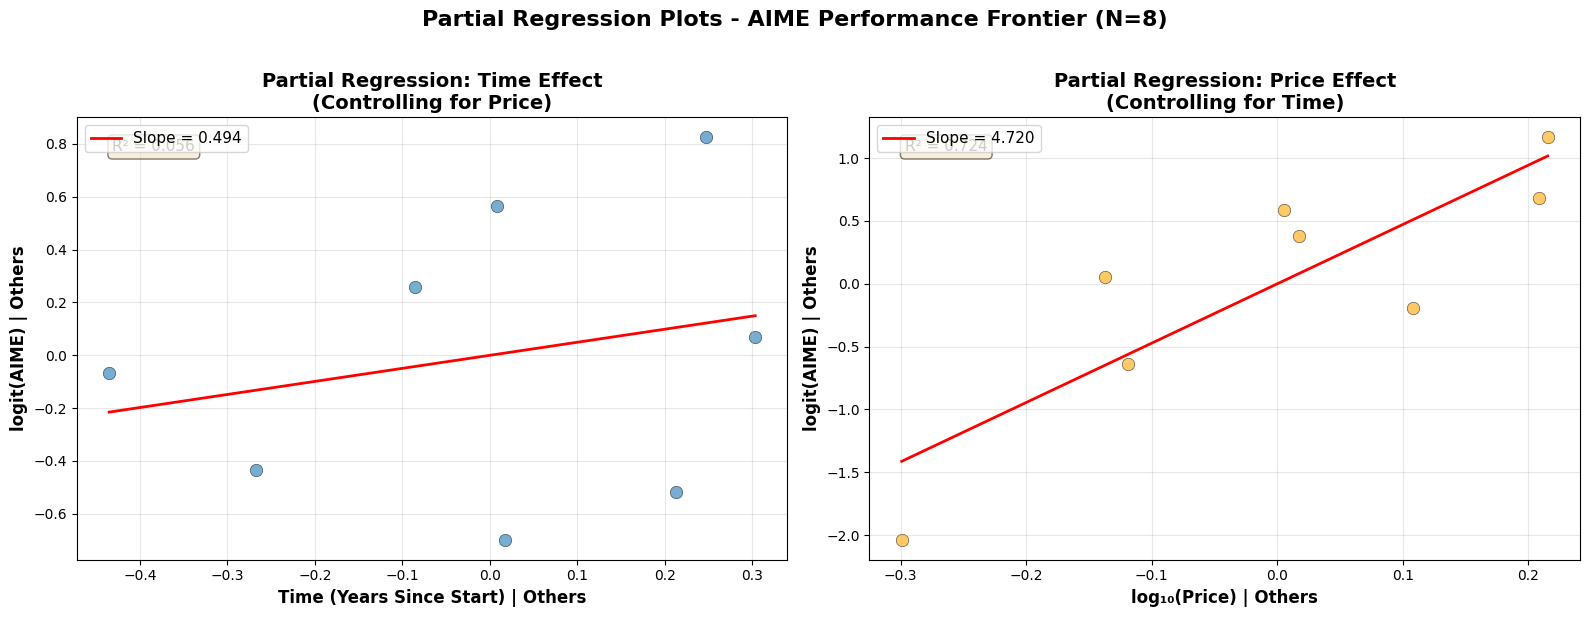

## Partial Regression Plots

Partial regression plots (also called added-variable plots) show the relationship between each independent variable and the dependent variable after controlling for other variables. These plots help visualize the unique contribution of each predictor.